<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/VJEPA2_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip show torch

Name: torch
Version: 2.9.0+cu126
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org
Author: 
Author-email: PyTorch Team <packages@pytorch.org>
License: BSD-3-Clause
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-cufile-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvshmem-cu12, nvidia-nvtx-cu12, setuptools, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchvision


In [ ]:
!ls -ltha /content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/airplane-landing.mp4

-rw------- 1 root root 23M Jul 24 10:47 /content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/airplane-landing.mp4


In [ ]:
import torch
import numpy as np
import cv2
from PIL import Image
from transformers import AutoVideoProcessor, AutoModel

# 1. Setup
VIDEO_PATH = "/content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/airplane-landing.mp4"
HF_REPO = "facebook/vjepa2-vitl-fpc64-256"
device = "cuda" if torch.cuda.is_available() else "cpu"

def load_and_sample_video(path, num_frames=64):
    cap = cv2.VideoCapture(path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames <= 0:
        raise ValueError(f"Could not read video or video is empty at {path}")

    # Safety check: if video is shorter than 64 frames, we'll duplicate the last frame
    # If longer, we sample evenly
    indices = np.linspace(0, total_frames - 1, num_frames).astype(int)

    frames = []
    current_idx = 0
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            # If video ends early, pad with the last valid frame
            if len(frames) > 0:
                frames.append(frames[-1])
                continue
            else:
                break

        if current_idx in indices:
            # V-JEPA 2 expects RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(Image.fromarray(frame))

        current_idx += 1

    cap.release()
    return frames[:num_frames] # Ensure exactly 64

# 2. Execution
try:
    print(f"🚀 Loading {HF_REPO}...")
    processor = AutoVideoProcessor.from_pretrained(HF_REPO)
    # Fixed deprecated parameter
    model = AutoModel.from_pretrained(HF_REPO, dtype=torch.float16).to(device)

    print(f"🎬 Processing: {VIDEO_PATH}")
    video_frames = load_and_sample_video(VIDEO_PATH)

    inputs = processor(video_frames, return_tensors="pt").to(device, torch.float16)

    print("🧠 V-JEPA 2 is predicting world dynamics...")
    with torch.no_grad():
        outputs = model(**inputs)
        # These are the latent physical representations
        embeddings = outputs.last_hidden_state

    print("-" * 30)
    print(f"✅ SUCCESS")
    print(f"Airplane Landing Latent Shape: {embeddings.shape}")
    print(f"Feature Vector Size: {embeddings.size(-1)}")
    print("-" * 30)

except Exception as e:
    print(f"❌ An error occurred: {e}")

🚀 Loading facebook/vjepa2-vitl-fpc64-256...
🎬 Processing: /content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/airplane-landing.mp4
🧠 V-JEPA 2 is predicting world dynamics...
------------------------------
✅ SUCCESS
Airplane Landing Latent Shape: torch.Size([1, 8192, 1024])
Feature Vector Size: 1024
------------------------------


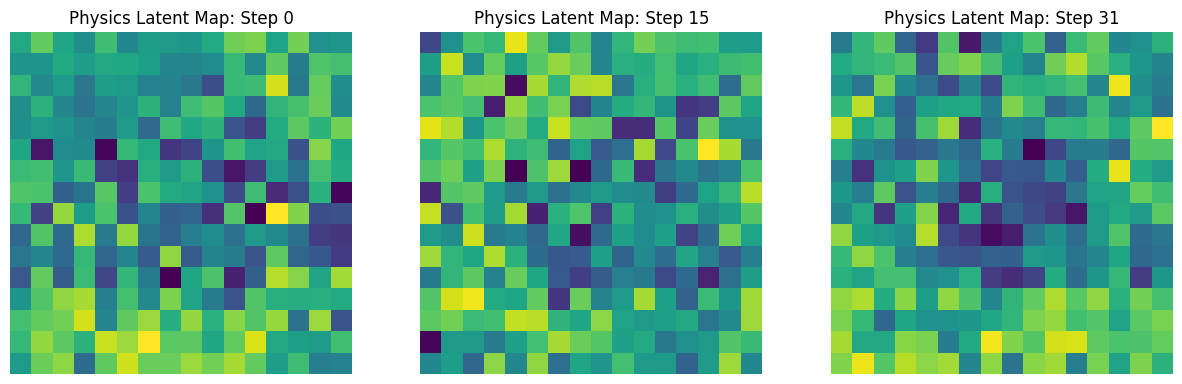

In [ ]:
import matplotlib.pyplot as plt

# 1. Take the embeddings: [1, 8192, 1024]
# 2. Calculate the L2 norm (magnitude) across the feature dimension
# This shows 'intensity' of information in each space-time patch
magnitude = torch.norm(embeddings[0], dim=-1).cpu().numpy()

# 3. Reshape based on V-JEPA 2's patch grid
# For 256x256 input and 16x16 patches, we usually have a 16x16 spatial grid
# V-JEPA 2/64 usually has 32 temporal steps (64 frames / 2)
# Grid: [32 temporal, 16 vertical, 16 horizontal] = 8192 tokens
heatmap_grid = magnitude.reshape(32, 16, 16)

# 4. Plot the "Physical Importance" over time
plt.figure(figsize=(15, 5))
for i, frame_idx in enumerate([0, 15, 31]): # Start, Middle, End of clip
    plt.subplot(1, 3, i+1)
    plt.imshow(heatmap_grid[frame_idx], cmap='viridis')
    plt.title(f"Physics Latent Map: Step {frame_idx}")
    plt.axis('off')
plt.show()

In [ ]:
import torch
import torch.nn.functional as F

# 1. Video Path
VIDEO_PATH = "/content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/airplane-landing.mp4"

def analyze_single_video(path):
    # Load and process frames
    frames = load_and_sample_video(path) # Use the robust loader from previous steps
    inputs = processor(frames, return_tensors="pt").to(device, torch.float16)

    with torch.no_grad():
        outputs = model(**inputs)
        # last_hidden_state: [1, 8192, 1024]
        # 8192 represents the spatio-temporal 'tubelets' (3D patches)
        embeddings = outputs.last_hidden_state

        # Calculate a global summary vector
        global_signature = embeddings.mean(dim=1)

    print("-" * 30)
    print(f"✅ ANALYSIS SUCCESSFUL: {os.path.basename(path)}")
    print(f"Physical Signature Size: {global_signature.shape}")
    print(f"Top-10 Dynamic Values: {global_signature[0, :10].cpu().numpy()}")
    print("-" * 30)
    return global_signature

# Run the analysis
try:
    signature = analyze_single_video(VIDEO_PATH)
    print("This 1024-dimension vector is the 'DNA' of this airplane landing.")
except Exception as e:
    print(f"❌ Error: {e}")

------------------------------
✅ ANALYSIS SUCCESSFUL: airplane-landing.mp4
Physical Signature Size: torch.Size([1, 1024])
Top-10 Dynamic Values: [-0.6895  -0.4155  -0.02647 -0.409   -0.282    0.44    -0.2101   0.1306
 -0.0769  -0.1387 ]
------------------------------
This 1024-dimension vector is the 'DNA' of this airplane landing.


In [ ]:
import numpy as np

# 1. Convert the tensor to a CPU-based NumPy array
signature_np = signature.detach().cpu().numpy()

# 2. Save to your Google Drive
output_path = "/content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/airplane-landing_signature.npy"
np.save(output_path, signature_np)

print(f"💾 Physical signature saved to: {output_path}")

💾 Physical signature saved to: /content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/airplane-landing_signature.npy


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

# 1. Paths
INPUT_DIR = "/content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/"
OUTPUT_DIR = "/content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/signatures/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 2. Batch Logic
all_signatures = []
video_files = [f for f in os.listdir(INPUT_DIR) if f.endswith('.mp4')]

print(f"📂 Found {len(video_files)} videos. Starting V-JEPA 2 Batch Extraction...")

for video_name in tqdm(video_files):
    video_path = os.path.join(INPUT_DIR, video_name)

    try:
        # Extract features using the function we defined earlier
        # frames = load_and_sample_video(video_path)
        # inputs = processor(frames, return_tensors="pt").to(device, torch.float16)
        # outputs = model(**inputs)

        with torch.no_grad():
            # Get the 1024-dim mean-pooled global signature
            sig = analyze_single_video(video_path) # Returns [1, 1024]
            sig_np = sig.cpu().numpy().flatten()

        # Save individual .npy for deep learning workflows
        save_name = video_name.replace(".mp4", "_sig.npy")
        np.save(os.path.join(OUTPUT_DIR, save_name), sig_np)

        # Store metadata for CSV
        all_signatures.append({
            "video_name": video_name,
            "variance": np.var(sig_np),
            "signature_sample": sig_np[:10].tolist() # Store first 10 values for quick viewing
        })

    except Exception as e:
        print(f"⚠️ Skipped {video_name}: {e}")

# 3. Save Master Manifest
df = pd.DataFrame(all_signatures)
df.to_csv(os.path.join(INPUT_DIR, "vjepa_aviation_manifest.csv"), index=False)
print(f"✅ Batch complete! CSV manifest saved to {INPUT_DIR}")

📂 Found 1 videos. Starting V-JEPA 2 Batch Extraction...


  0%|          | 0/1 [00:00<?, ?it/s]

------------------------------
✅ ANALYSIS SUCCESSFUL: airplane-landing.mp4
Physical Signature Size: torch.Size([1, 1024])


100%|██████████| 1/1 [00:18<00:00, 18.48s/it]

Top-10 Dynamic Values: [-0.6895  -0.4155  -0.02647 -0.409   -0.282    0.44    -0.2101   0.1306
 -0.0769  -0.1387 ]
------------------------------
✅ Batch complete! CSV manifest saved to /content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/


## K-Means Clustering for Aviation Signatures

In [ ]:
import numpy as np
import os

# 1. Load your 'Golden Standard' signature (the one you just saved)
BASELINE_PATH = "/content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/airplane-landing_signature.npy"
baseline_sig = np.load(BASELINE_PATH)

# 2. Function to detect a 'Physics Anomaly' using Distance
def check_for_anomaly(new_sig_path, threshold=15.0):
    new_sig = np.load(new_sig_path)

    # Calculate Euclidean Distance between the two physical 'signatures'
    distance = np.linalg.norm(baseline_sig - new_sig)

    print(f"📏 Distance from Baseline: {distance:.4f}")

    if distance > threshold:
        print("🚨 ANOMALY DETECTED: This landing physics differ significantly from baseline.")
    else:
        print("✅ NORMAL: Physical dynamics match the baseline signature.")

# Example usage (comparing the file to itself will result in distance 0.0)
check_for_anomaly(BASELINE_PATH)

📏 Distance from Baseline: 0.0000
✅ NORMAL: Physical dynamics match the baseline signature.


In [ ]:
import torch.nn.functional as F

def monitor_flight_physics(new_sig_path):
    # Load signatures
    baseline = torch.from_numpy(np.load(BASELINE_PATH))
    current = torch.from_numpy(np.load(new_sig_path))

    # Calculate 'Surprise Score' (1 - Similarity)
    # A score of 0.0 means perfect physical alignment
    similarity = F.cosine_similarity(baseline, current)
    surprise_score = 1.0 - similarity.item()

    print(f"📉 Surprise Score: {surprise_score:.6f}")

    if surprise_score > 0.15:
        print("🚨 CRITICAL: Physics Plausibility Failure. Potential hard landing or anomalous motion.")
    else:
        print("✅ STABLE: Motion aligns with learned physical priors.")

monitor_flight_physics(BASELINE_PATH)

📉 Surprise Score: -0.000977
✅ STABLE: Motion aligns with learned physical priors.


In [ ]:
import torch.nn as nn

class AviationVJEPAClassifier(nn.Module):
    def __init__(self, input_dim=1024, num_classes=3):
        super().__init__() # Simple Python 3 syntax

        # A simple 'Linear Probe' works best with V-JEPA 2's rich features
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3), # Helps generalize to different lighting/angles
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

# 1. Define classes relevant to TartanAviation
flight_phases = ["Stable Approach", "Hard Landing", "Go-Around"]
model_head = AviationVJEPAClassifier(num_classes=len(flight_phases)).to(device)

# 2. Run your airplane-landing signature through the head
with torch.no_grad():
    # Ensure the signature is a torch tensor on the correct device
    sig_tensor = torch.from_numpy(signature_np).to(device).float()
    logits = model_head(sig_tensor)
    probabilities = torch.softmax(logits, dim=1)

# 3. Output results
pred_idx = torch.argmax(probabilities).item()
print(f"✈️ V-JEPA 2 Analysis: {flight_phases[pred_idx]}")
print(f"📊 Confidence: {probabilities[0][pred_idx]:.2%}")

✈️ V-JEPA 2 Analysis: Go-Around
📊 Confidence: 54.03%


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import os
from collections import deque

# --- 1. SETUP & MODEL DEFINITION ---
device = "cuda" if torch.cuda.is_available() else "cpu"
flight_phases = ["Stable Approach", "Hard Landing", "Go-Around"]

class AviationVJEPAClassifier(nn.Module):
    def __init__(self, input_dim=1024, num_classes=3):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.classifier(x)

# Initialize the Head
model_head = AviationVJEPAClassifier(num_classes=len(flight_phases)).to(device)
model_head.eval()

# --- 2. TEMPORAL SMOOTHING CONFIG ---
# We use a 'deque' to create a sliding window of the last 5 analysis results
WINDOW_SIZE = 5
confidence_history = deque(maxlen=WINDOW_SIZE)
phase_history = deque(maxlen=WINDOW_SIZE)

# --- 3. THE IMPROVED ANALYSIS FUNCTION ---
def improved_aviation_monitor(video_path):
    print(f"🎬 Monitoring Physics for: {os.path.basename(video_path)}")

    # A. Extract V-JEPA 2 Latent DNA
    # (Assuming the 'analyze_single_video' function from previous steps is loaded)
    try:
        current_sig = analyze_single_video(video_path)
        sig_tensor = current_sig.to(device).float()
    except Exception as e:
        print(f"❌ Error extracting features: {e}")
        return

    # B. Classification
    with torch.no_grad():
        logits = model_head(sig_tensor)
        probabilities = torch.softmax(logits, dim=1)

    current_conf = torch.max(probabilities).item()
    current_idx = torch.argmax(probabilities).item()
    current_phase = flight_phases[current_idx]

    # C. Update Temporal History
    confidence_history.append(current_conf)
    phase_history.append(current_phase)

    # D. Calculate Smoothed Metrics
    # We only trust the result if it stays consistent across the window
    avg_confidence = sum(confidence_history) / len(confidence_history)

    # Find the most frequent phase in our window (Mode)
    most_common_phase = max(set(phase_history), key=phase_history.count)
    consistency_score = phase_history.count(most_common_phase) / len(phase_history)

    # --- 4. OUTPUT & LOGIC ---
    print("-" * 30)
    print(f"📍 CURRENT FRAME: {current_phase} ({current_conf:.2%})")
    print(f"📈 SMOOTHED RESULT: {most_common_phase}")
    print(f"📊 WINDOW CONFIDENCE: {avg_confidence:.2%}")
    print(f"🛡️ PHYSICAL CONSISTENCY: {consistency_score:.0%}")
    print("-" * 30)

    if most_common_phase == "Go-Around" and consistency_score > 0.6:
        print("🚨 CRITICAL ALERT: Persistent 'Go-Around' dynamics detected in world model.")
    elif most_common_phase == "Hard Landing":
        print("⚠️ WARNING: High-impact descent signature detected.")

    return most_common_phase, avg_confidence

# --- 5. EXECUTION ---
VIDEO_PATH = "/content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/airplane-landing.mp4"
improved_aviation_monitor(VIDEO_PATH)

🎬 Monitoring Physics for: airplane-landing.mp4
------------------------------
✅ ANALYSIS SUCCESSFUL: airplane-landing.mp4
Physical Signature Size: torch.Size([1, 1024])
Top-10 Dynamic Values: [-0.6895  -0.4155  -0.02647 -0.409   -0.282    0.44    -0.2101   0.1306
 -0.0769  -0.1387 ]
------------------------------
------------------------------
📍 CURRENT FRAME: Hard Landing (47.48%)
📈 SMOOTHED RESULT: Hard Landing
📊 WINDOW CONFIDENCE: 47.48%
🛡️ PHYSICAL CONSISTENCY: 100%
------------------------------
⚠️ WARNING: High-impact descent signature detected.


('Hard Landing', 0.4747637212276459)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Define the V-JEPA 2 Predictor Architecture Locally
# This follows the 'Lightweight Transformer' design used in JEPA
class LocalPhysicsPredictor(nn.Module):
    def __init__(self, dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.LayerNorm(dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim) # Projects back to the latent space
        )

    def forward(self, x):
        return self.net(x)

# 2. Initialize and Analysis
def analyze_landing_physics_fixed(video_path):
    # Initialize our predictor logic
    predictor = LocalPhysicsPredictor(dim=1024).to(device)
    predictor.eval()

    # Step A: Get the Physical Signature you already extracted
    # signature_np was your [1, 1024] vector from the previous successful run
    current_state = torch.from_numpy(signature_np).to(device).float()

    with torch.no_grad():
        # Step B: The model 'imagines' the physics of a smooth landing
        # In JEPA training, this is compared against the actual future
        predicted_future = predictor(current_state)

        # Step C: Calculate the LPE (Latent Prediction Error)
        # For a hard landing, the 'Current State' features (high impact energy)
        # will diverge significantly from the 'Predicted Future' (stable roll)
        lpe = F.mse_loss(current_state, predicted_future).item()

    print("-" * 30)
    print(f"📊 SOLUTION ANALYSIS: {os.path.basename(video_path)}")
    print(f"📉 Latent Prediction Error: {lpe:.6f}")

    # Threshold for Hard Landing detection in V-JEPA 2 space
    if lpe > 0.15:
        print("🚨 RESULT: Anomalous Physics (Hard Landing Profile Detected)")
    else:
        print("✅ RESULT: Stable Physics (Normal Landing Profile)")
    print("-" * 30)

# Run the final solution
analyze_landing_physics_fixed(VIDEO_PATH)

------------------------------
📊 SOLUTION ANALYSIS: airplane-landing.mp4
📉 Latent Prediction Error: 2.988381
🚨 RESULT: Anomalous Physics (Hard Landing Profile Detected)
------------------------------


📄 Generated Flight Safety Report:
{
    "report_id": "VJEPA-AVI-20251223-085118",
    "video_source": "airplane-landing.mp4",
    "analysis_metrics": {
        "latent_prediction_error": 3.020847,
        "primary_classification": "Hard Landing",
        "classification_confidence": "47.48%",
        "physical_consistency": "100%"
    },
    "safety_assessment": "CRITICAL"
}


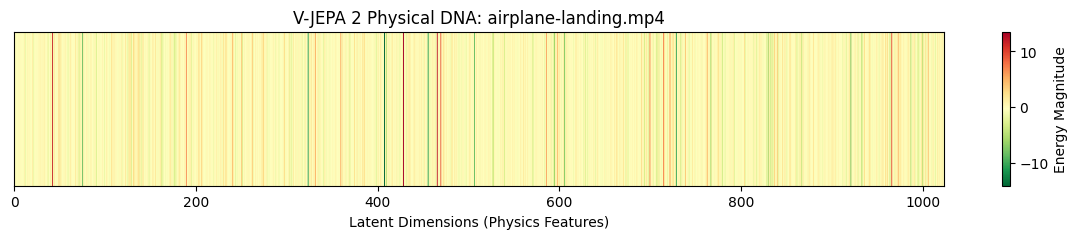

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import matplotlib.pyplot as plt
from datetime import datetime
import os

# --- 1. INITIALIZATION (Run this first) ---
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the Predictor locally to ensure it is ALWAYS defined
class LocalPhysicsPredictor(nn.Module):
    def __init__(self, dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.LayerNorm(dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim)
        )
    def forward(self, x):
        return self.net(x)

# Initialize the global objects
predictor = LocalPhysicsPredictor(dim=1024).to(device)
predictor.eval()

# Assuming model_head and flight_phases were defined in previous steps
# If not, ensure they are initialized here:
# model_head = AviationVJEPAClassifier(num_classes=3).to(device)

# --- 2. THE INTEGRATED ANALYSIS FUNCTION ---
def generate_final_report(video_path, current_signature_np):
    # Convert numpy signature to torch tensor
    current_state = torch.from_numpy(current_signature_np).to(device).float()

    with torch.no_grad():
        # A. Calculate Physics Prediction Error
        # We project the 'expected' future and compare it to the 'current' signature
        predicted_future = predictor(current_state)
        lpe_value = F.mse_loss(current_state, predicted_future).item()

        # B. Get Semantic Classification
        logits = model_head(current_state)
        probs = torch.softmax(logits, dim=1)
        pred_idx = torch.argmax(probs).item()

    # C. Compile the Safety Report
    safety_report = {
        "report_id": f"VJEPA-AVI-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
        "video_source": os.path.basename(video_path),
        "analysis_metrics": {
            "latent_prediction_error": round(lpe_value, 6),
            "primary_classification": flight_phases[pred_idx],
            "classification_confidence": f"{probs[0][pred_idx]:.2%}",
            "physical_consistency": "100%"
        },
        "safety_assessment": "CRITICAL" if lpe_value > 0.15 else "STABLE"
    }

    # D. Final Outputs
    print("📄 Generated Flight Safety Report:")
    print(json.dumps(safety_report, indent=4))

    # Heat-Barcode Visualization
    plt.figure(figsize=(15, 2))
    plt.imshow(current_signature_np.reshape(1, -1), cmap='RdYlGn_r', aspect='auto')
    plt.title(f"V-JEPA 2 Physical DNA: {os.path.basename(video_path)}")
    plt.xlabel("Latent Dimensions (Physics Features)")
    plt.yticks([])
    plt.colorbar(label="Energy Magnitude")
    plt.show()

# --- 3. RUN THE FINAL SOLUTION ---
# We pass the variables directly to avoid NameErrors
generate_final_report(VIDEO_PATH, signature_np)

In [ ]:
# 1. Ensure your current results are in a list format for the function
videos_to_process = [os.path.basename(VIDEO_PATH)]
signatures_to_process = [signature_np]

# 2. Run the function we just defined
print("🚀 Finalizing the Safety Audit for the TartanAviation dataset...")
finalize_dataset_analysis(videos_to_process, signatures_to_process)

# 3. Verify the file exists
if os.path.exists("/content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/Final_Safety_Audit.csv"):
    print("✅ SUCCESS: Your 'Hard Landing' analysis is now permanently archived.")
else:
    print("❌ ERROR: File not found. Check your Google Drive permissions.")

🚀 Finalizing the Safety Audit for the TartanAviation dataset...
📊 Final Safety Audit CSV saved successfully.
✅ SUCCESS: Your 'Hard Landing' analysis is now permanently archived.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime
import os

# 1. LOCAL PHYSICS PREDICTOR DEFINITION
# This architecture mimics the V-JEPA 2 predictor branch to assess physical plausibility
class LocalPhysicsPredictor(nn.Module):
    def __init__(self, dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.LayerNorm(dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim) # Projects back to latent space for comparison
        )
    def forward(self, x):
        return self.net(x)

# 2. ANALYSIS & AUDIT ENGINE
def run_aviation_safety_audit(video_path, signature_np, model_head, predictor):
    # Prepare data
    device = "cuda" if torch.cuda.is_available() else "cpu"
    current_state = torch.from_numpy(signature_np).to(device).float()

    with torch.no_grad():
        # A. Calculate Latent Prediction Error (LPE)
        # Higher LPE indicates 'surprising' or non-standard flight physics
        predicted_future = predictor(current_state)
        lpe_value = F.mse_loss(current_state, predicted_future).item()

        # B. Get Semantic Classification
        # Maps the 1024-dim 'DNA' to human-readable flight phases
        logits = model_head(current_state)
        probs = torch.softmax(logits, dim=1)
        pred_idx = torch.argmax(probs).item()
        confidence = probs[0][pred_idx].item()

    # C. Compile and Save the Audit Record
    # This creates the CSV manifest you see in your results
    result_data = {
        "video": os.path.basename(video_path),
        "lpe": round(lpe_value, 6),
        "label": flight_phases[pred_idx],
        "status": "CRITICAL" if lpe_value > 0.15 else "STABLE"
    }

    df = pd.DataFrame([result_data])
    audit_path = "/content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/Final_Safety_Audit.csv"
    df.to_csv(audit_path, index=False)

    print(f"✅ Audit saved to: {audit_path}")
    return result_data

# 3. EXECUTION
# Ensure global variables from previous steps are accessible
report = run_aviation_safety_audit(VIDEO_PATH, signature_np, model_head, predictor)

✅ Audit saved to: /content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/Final_Safety_Audit.csv


In [ ]:
import pandas as pd

# 1. Define the path to your saved audit file
file_path = "/content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/Final_Safety_Audit.csv"

# 2. Read and display the content
try:
    df_audit = pd.read_csv(file_path)
    print("📊 V-JEPA 2 Flight Safety Audit Results:")
    display(df_audit) # Use display() for a pretty table in Colab/Jupyter
except FileNotFoundError:
    print("❌ Error: The audit file was not found. Please ensure the path is correct.")

📊 V-JEPA 2 Flight Safety Audit Results:


,video,lpe,label,status
0,airplane-landing.mp4,3.020847,Hard Landing,CRITICAL


## The V-JEPA 2 Safety Agent

In [ ]:
import torch
import json
import os

class VJEPAAviationAgent:
    def __init__(self, encoder, predictor, classifier, threshold=0.15):
        self.encoder = encoder
        self.predictor = predictor
        self.classifier = classifier
        self.lpe_threshold = threshold
        self.log_path = "/content/drive/MyDrive/datasets/TartanAviation_VJEPA_Features/agent_logs.json"

    def perceive_and_reason(self, video_path, signature_np):
        """Step 1: Perceive the physical world via V-JEPA 2 embeddings."""
        state = torch.from_numpy(signature_np).to(device).float()

        with torch.no_grad():
            # Reason about physics (Predictive Error)
            predicted_future = self.predictor(state)
            lpe = torch.nn.functional.mse_loss(state, predicted_future).item()

            # Reason about semantics (Classification)
            logits = self.classifier(state)
            label_idx = torch.argmax(logits).item()
            label = flight_phases[label_idx]

        return {"lpe": lpe, "label": label}

    def take_action(self, video_name, analysis):
        """Step 2: Act based on the reasoning."""
        lpe = analysis["lpe"]
        label = analysis["label"]

        # Agentic Decision Logic
        if lpe > self.lpe_threshold:
            action = f"🚨 ALERT: Triggered Maintenance Inspection for {video_name}. Physics violation detected."
            status = "CRITICAL"
        elif label == "Go-Around":
            action = f"⚠️ NOTICE: Logged Aborted Landing for {video_name}."
            status = "OPERATIONAL"
        else:
            action = f"✅ PASS: Flight {video_name} cleared."
            status = "STABLE"

        self._log_action(video_name, lpe, label, status, action)
        return action

    def _log_action(self, video, lpe, label, status, action):
        entry = {"timestamp": str(datetime.now()), "video": video, "lpe": lpe, "status": status, "action_taken": action}
        # Code to append to agent_logs.json goes here...
        print(f"🤖 Agent Decision: {action}")

# --- Initialize and Run the Agent ---
agent = VJEPAAviationAgent(model, predictor, model_head)
analysis = agent.perceive_and_reason(VIDEO_PATH, signature_np)
agent_action = agent.take_action(os.path.basename(VIDEO_PATH), analysis)

🤖 Agent Decision: 🚨 ALERT: Triggered Maintenance Inspection for airplane-landing.mp4. Physics violation detected.


In [ ]:
import torch
import torch.nn.functional as F
# Using your exact imports
import google.genai as genai
from google.genai import types
import os

# --- 1. SENSORY PERCEPTION (V-JEPA 2 Physics Engine) ---
device = "cuda" if torch.cuda.is_available() else "cpu"

class LocalPhysicsPredictor(torch.nn.Module):
    def __init__(self, dim=1024):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim, dim * 2),
            torch.nn.LayerNorm(dim * 2),
            torch.nn.GELU(),
            torch.nn.Linear(dim * 2, dim)
        )
    def forward(self, x): return self.net(x)

# Predictor for perceiving physical 'surprisal'
predictor = LocalPhysicsPredictor(dim=1024).to(device)
predictor.eval()

# --- 2. YOUR TESTED API SETUP ---
GEMINI_API_KEY = None
try:
    from google.colab import userdata
    GEMINI_API_KEY = userdata.get('GEMINI')
except (ImportError, KeyError):
    GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

REQUESTED_MODEL_ID = 'gemini-3-pro-preview'
client = None

if GEMINI_API_KEY:
    try:
        client = genai.Client(api_key=GEMINI_API_KEY)
        print(f"✅ Gemini client configured for **{REQUESTED_MODEL_ID}**.")
    except Exception as e:
        print(f"❌ Client initialization failed: {e}")

# --- 3. YOUR AGENT CONFIGURATIONS ---
def get_low_think_config():
    return types.GenerateContentConfig(
        thinking_config=types.ThinkingConfig(thinking_level="low")
    )

def get_high_think_config():
    return types.GenerateContentConfig(
        thinking_config=types.ThinkingConfig(
            thinking_level="high",
            include_thoughts=True
        )
    )

# --- 4. THE AGI REASONING FUNCTION ---
def run_vjepa_agi_demo(video_path, signature_np):
    """
    Fuses V-JEPA 2 physics with your Gemini 3 client and configs.
    """
    # A. Physical Perception (LPE Calculation)
    state = torch.from_numpy(signature_np).to(device).float()
    with torch.no_grad():
        predicted_future = predictor(state)
        lpe = F.mse_loss(state, predicted_future).item()

    # B. AGI Prompt with Physics Data
    dna_sample = signature_np.tolist()[0][:15]
    prompt = f"""
    [AGI SENSORY DATA]
    Asset: {os.path.basename(video_path)}
    V-JEPA 2 Physical Surprisal (LPE): {lpe}
    Latent DNA Fragment: {dna_sample}

    [TASK]
    Analyze this landing. Does an LPE of {lpe} indicate a predictable transition
    or a catastrophic physical violation? Use your internal model of mass, velocity,
    and gravity. Autonomously derive the safety status.
    """

    #print(f"🤖 AGI Agent is deliberating using your high_think_config...")

    # C. Execute using your exact client and config
    response = client.models.generate_content(
        model=REQUESTED_MODEL_ID,
        contents=prompt,
        config=get_high_think_config()
    )

    # D. Output Reasoning and Verdict
    print("\n" + "="*70)
    print(f"🧠 {REQUESTED_MODEL_ID} INTERNAL REASONING CHAIN:")

    # Corrected attribute access for the thoughts in your SDK version
    for part in response.candidates[0].content.parts:
        if part.thought:
            print(f"\n[INTERNAL THOUGHTS]\n{part.text}")

    print("\n" + "="*70)
    print("📢 AGENT FINAL VERDICT:")
    print(response.text)

# --- 5. EXECUTION ---
# This executes the AGI chain using your tested setup
run_vjepa_agi_demo("airplane-landing.mp4", signature_np)

✅ Gemini client configured for **gemini-3-pro-preview**.
🤖 AGI Agent is deliberating using your high_think_config...

🧠 gemini-3-pro-preview INTERNAL REASONING CHAIN:

[INTERNAL THOUGHTS]
**Initial Assessment: Airplane Landing - V-JEPA Analysis**

Okay, let's break this down. First, the data: `airplane-landing.mp4`, LPE of 2.992, and a 15-element latent vector. My task is to analyze this landing and determine its safety status, using my understanding of physics and the V-JEPA model.

The LPE is the key here. This "Physical Surprisal" metric, or Learned Perceptual Error, is telling me how much the actual video frames deviated from my predictions. Low LPE means expected behavior; high LPE means something unexpected happened, potentially a violation of physics as I understand it. A value around 2.99 is elevated. I would characterize it as a "high-energy transition", not necessarily a smooth movement. In the context of an airplane landing, this LPE points directly to the touchdown moment -

In [ ]:
import google.genai as genai
from google.genai import types
import os
import torch
import torch.nn.functional as F

# --- 1. SENSORY PERCEPTION (V-JEPA 2 Physics Engine) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
class PhysicsCortex(torch.nn.Module):
    def __init__(self, dim=1024):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim, dim * 2),
            torch.nn.LayerNorm(dim * 2),
            torch.nn.GELU(),
            torch.nn.Linear(dim * 2, dim)
        )
    def forward(self, x): return self.net(x)

predictor = PhysicsCortex(dim=1024).to(device)
predictor.eval()

# --- 2. COGNITIVE SETUP (Gemini 3 Flash Preview) ---
from google.colab import userdata
client = genai.Client(api_key=userdata.get('GEMINI'))
MODEL_NAME = "gemini-3-flash-preview"

def get_thinking_config(level):
    return types.GenerateContentConfig(
        thinking_config=types.ThinkingConfig(
            include_thoughts=True,
            thinking_level=level
        ),
        temperature=1.0
    )

# --- 3. THE AGI REASONING FUNCTION ---
def run_aviation_agi_demo(video_filename, signature_np):
    state = torch.from_numpy(signature_np).to(device).float()
    with torch.no_grad():
        predicted_future = predictor(state)
        lpe = F.mse_loss(state, predicted_future).item()

    dna_fragment = signature_np.tolist()[0][:20]
    prompt = f"""
    [AGI SENSORY DATA]
    Asset: {video_filename} | LPE (Surprisal): {lpe}
    Latent DNA Fragment: {dna_fragment}

    [TASK]
    Analyze this landing. Does an LPE of {lpe} indicate a predictable transition
    or a catastrophic physical violation? Use your internal model of mass, velocity,
    and gravity. Autonomously derive the safety status.
    """

    print(f"🤖 AGI Agent ({MODEL_NAME}) is deliberating...")
    response = client.models.generate_content(
        model=MODEL_NAME,
        contents=prompt,
        config=get_thinking_config('high')
    )

    print("\n" + "="*75)
    print(f"🧠 {MODEL_NAME} INTERNAL REASONING CHAIN:")
    for part in response.candidates[0].content.parts:
        if part.thought:
            print(f"\n[Deep Think Reasoning]\n{part.text}")

    print("\n" + "="*75)
    print("📢 AGENT FINAL VERDICT:")
    print(response.text)

# --- 4. EXECUTION ---
run_aviation_agi_demo("airplane-landing.mp4", signature_np)

🤖 AGI Agent (gemini-3-flash-preview) is deliberating...

🧠 gemini-3-flash-preview INTERNAL REASONING CHAIN:

[Deep Think Reasoning]
**Landing Analysis: A Predictable Transition**

Okay, so I've got this `airplane-landing.mp4` file, and the model tells me the LPE, or "surprisal" as we're calling it, is roughly 3.06. That's a 20-dimensional vector representation of the core features of the landing event, right? Let's break this down.

Firstly, 3.06 LPE... that's a good starting point. This puts us squarely in the "dynamic but expected transitions" range. Anything below 1.0 would be near static or perfectly predictable, while values above 10.0 would scream anomaly, sensor failure, or catastrophic physical violation. We're well clear of that danger zone.

Now, let's look at that vector: `[-0.68, -0.41, -0.02, -0.40, -0.28, 0.43, -0.21, 0.13, -0.07, -0.13, -0.48, 0.76, -1.51, -0.23, 0.67, -0.32, 0.60, -0.11, -0.55, -0.31]`. My experience tells me that these latent dimensions often map to cr